# Usage

The typical workflow with `chromatopy` consists of the following steps:
1. Read calibration data of an external standard
    1. Define measured analyte
    2. Create a `Calibrator` to get a model for later concentration calculation
    3. Save Molecule with calibration information for later use
2. Read time-course data
    1. Define reaction conditions such as temperature and pH.
    2. Add previously saved Molecule with calibration information
    3. Export data as EnzymeML Document

## The ChromAnalyzer class

The `ChromAnalyzer` of `chromatopy` provides several methods for reading chromatographic data from various, adding and defining molecules, that allow extraction and processing of data. Information on a molecule is defined in regard to the intent of the measurement. This means that besides a molecule's name, its retention time, the initial concentration and respective unit are also added for time-course measurements.

### Read Data
Each of the [supported file formats](../../supported_formats/#supported-formats) has a corresponding reader function, namely `read_asm`, `read_agilent`, `read_chromeleon`, and `read_shimadzu`. Following arguments are common to all reader functions:

__Required Parameters__:  

- `path`: The path to the directory containing the chromatographic files.
- `ph`: The pH value of the measurement.
- `temperature`: The temperature of the measurement.
- `mode`: The mode of the measurement, either `calibration` or `timecourse`.

__Optional Parameters__:  

- `id`: A unique identifier for the `ChromAnalyzer` object. If not provided, the `path` is used as the ID.
- `name`: The name of the measurement. Defaults to "Chromatographic measurement".
- `values`: A list of reaction times corresponding to each file in the directory for timecourse measurements or concentrations for calibration measurements. If not provided, reaction times are extracted from file names when possible.
- `time_unit`: The unit of the time values `second`, `minute`, and `hour`, which can directly be imported from chromatopy. This is also optional if the unit is part of the file names.
- `temperature_unit`: The unit of the temperature. The default is Celsius (C).


__Returns__:  

- Returns a `ChromAnalyzer` object, which can be used to further analyze and manipulate the chromatographic data.

__Automatic Extraction from File Names__

`chromatopy` can automatically extract the reaction time and time unit or concentration values and concentration unit directly from the file names. This is particularly useful when files are named in a way that includes this information (e.g., `sample_10min.txt`, `a11 3.45 hours.json`, or `B02_35_sec.json`). However, this requires the file names to follow a specific format that `chromatopy` can recognize: It is assumed that the reaction time is the first numerical value which might have a decimal separator, followed by the name of the unit `sec`, `second`, `min`, `minute`, or `hour`. For concentration values, the first numerical value is assumed to be the concentration, followed by the name of the unit `mM`, `uM`, `nM`. If the file names do not follow this format, values and units need to be provided manually.

### Define Molecules
Molecules are defined using the `define_molecule` method. It adds a molecule to the list of molecules within the `ChromAnalyzer` object. This method requires several parameters, including the internal identifier, PubChem CID, and retention time, among others.

__Required parameters__:  

- `id`: Internal identifier of the molecule, such as `s0`, `ABTS` or `A0_34S`.
- `pubchem_cid`: PubChem CID of the molecule.
- `retention_time`: Retention time for peak annotation in minutes. If the molecule is not detected in the chromatogram, the retention time can be set to `None`.


__Optional parameters__:  

- `init_conc`: Initial concentration of the molecule. Defaults to `None`
- `conc_unit`: Unit of the concentration. Defaults to `None`.
- `name`: Name of the molecule. If not provided, the name is retrieved from the PubChem database. Defaults to `None`.
- `retention_tolerance`: Retention time tolerance for peak annotation in minutes. Defaults to `0.1`.
- `wavelength`: Wavelength of the detector on which the molecule was detected. Defaults to `None`.

__Returns__:  

- The method returns a `Molecule` object that is added to the `molecules` list within the `ChromAnalyzer` object.

__How it works__:

Once the molecule is defined, all peaks within the chromatographic data that match the retention time within the specified tolerance are annotated with the molecule's `id`, hence allowing for further analysis and processing of the data. This happens in the background. In the following assignment of a substrate and product molecule of a kinetic measurement is shown.




## Process calibration data

In this example, an enzymatic reaction is analyzed: S-adenosyl-L-homocysteine (SAH) is converted to Adenosine (Ado) by an SAH hydrolase. For both molecules, calibration measurements in the range from 25 µM to 800 µM were performed. In the following cells, the calibration data for both molecules is read in, visualized, and `Molecule` objects, containing the calibration information, are created for subsequent use with time-course data.

### External Standard

Besides kinetic data, the `ChromAnalyzer` can also be used to analyze calibration measurements and create standards for the quantification of molecules. 
The `add_standard` method adds fits a linear regression to the peaks which are assigned to a molecule and the provided concentrations.

__Required parameters__:
- `molecule`: The molecule for which the standard curve is being generated. This should be an instance of a molecule previously defined in the system.

__Optional parameters__:
- `visualize`: A boolean parameter that, if set to `True`, generates a plot of the standard curve for visualization. This is useful for confirming the accuracy of the calibration process.

__How it works__:  
Upon calling the `add_standard` method, the provided concentrations from the filenames of the individual chromatograms are used to fit a linear model with one parameter. The linear relationship between the concentration of $\text{Ana}$ and its peak area is defined by the equation:

$$
A_{\text{Molecule}} = a \times C_{\text{Molecule}}
$$

Where:
- **$A_{\text{Molecule}}$**: Peak area of $\text{Molecule}$.
- **$C_{\text{Molecule}}$**: Concentration of $\text{Molecule}$.
- **$a$**: Slope of the calibration curve, representing the sensitivity or response factor of $\text{Molecule}$.

The linear model including information on the valid calibration range is stored in the `standard` attribute of the `Molecule` object and can later be used for quantification of the molecule from time-course measurements.

Loaded 6 chromatograms.
🎯 Assigned S-Adenosylhomocysteine to 6 peaks


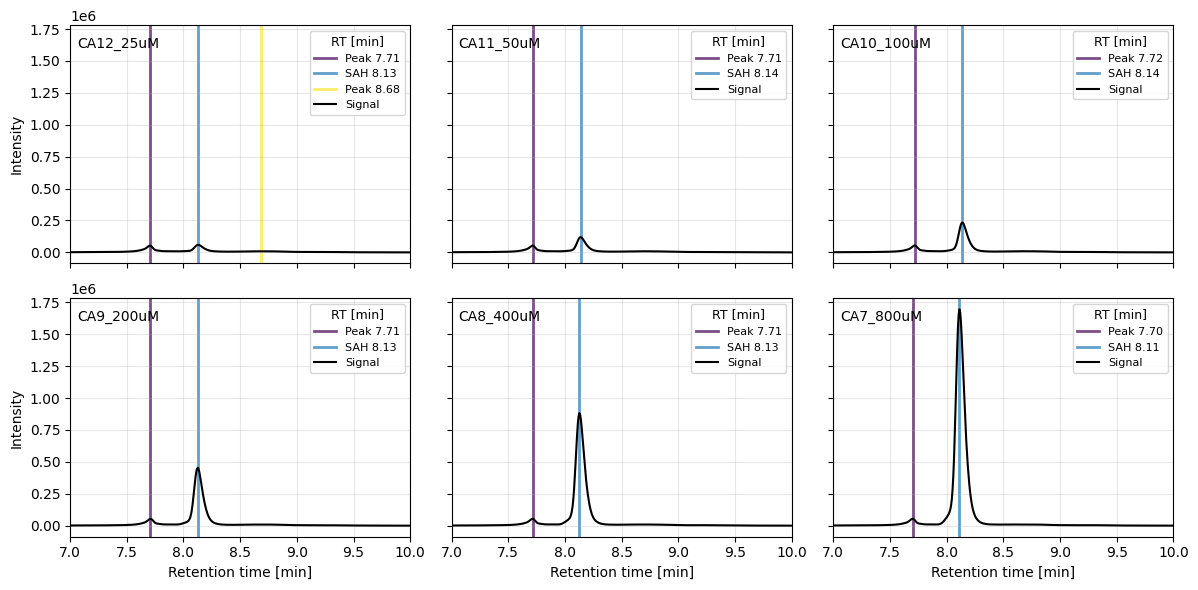

✅ Models have been successfully fitted.


                                         Model Overview                                         
┏━━━━━━━━━━━━┳━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Model Name ┃ AIC ┃ R squared ┃ RMSD          ┃ Equation ┃ Relative Parameter Standard Errors ┃
┡━━━━━━━━━━━━╇━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ linear     │ 218 │ 0.999     │ 64871367.9893 │ SAH * a  │ a: 1.0%,                           │
└────────────┴─────┴───────────┴───────────────┴──────────┴────────────────────────────────────┘

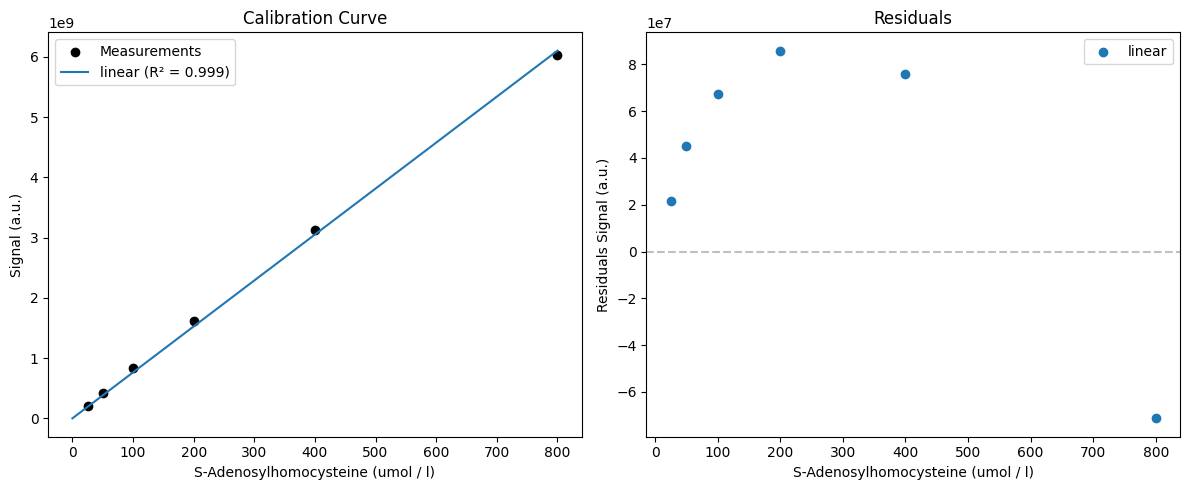

In [1]:
from chromatopy import ChromAnalyzer

# define directory with calibration data
dir_SIH = "data/calibration/SAH/allotrope"

# read calibration data
analyzer_substrate = ChromAnalyzer.read_asm(
    path=dir_SIH, ph=7.4, temperature=37, mode="calibration"
)


# define S-adenosyl-L-homocysteine (SAH)
SAH = analyzer_substrate.define_molecule(
    id="SAH",
    pubchem_cid="439155",
    retention_time=8.1,
)

# visualize calibration data
analyzer_substrate.visualize(n_cols=3, rt_min=7, rt_max=10, figsize=(12, 6))

# fit SAH peaks to linear model
analyzer_substrate.add_standard(
    molecule=SAH,
    visualize=True,
)

# save SAH molecule for re-use as json file
SAH.save_json("data/calibration/SAH.json")

The same procedure is repeated for the Adenosine (Ado) calibration data.

Loaded 6 chromatograms.
🎯 Assigned Adenosine to 6 peaks


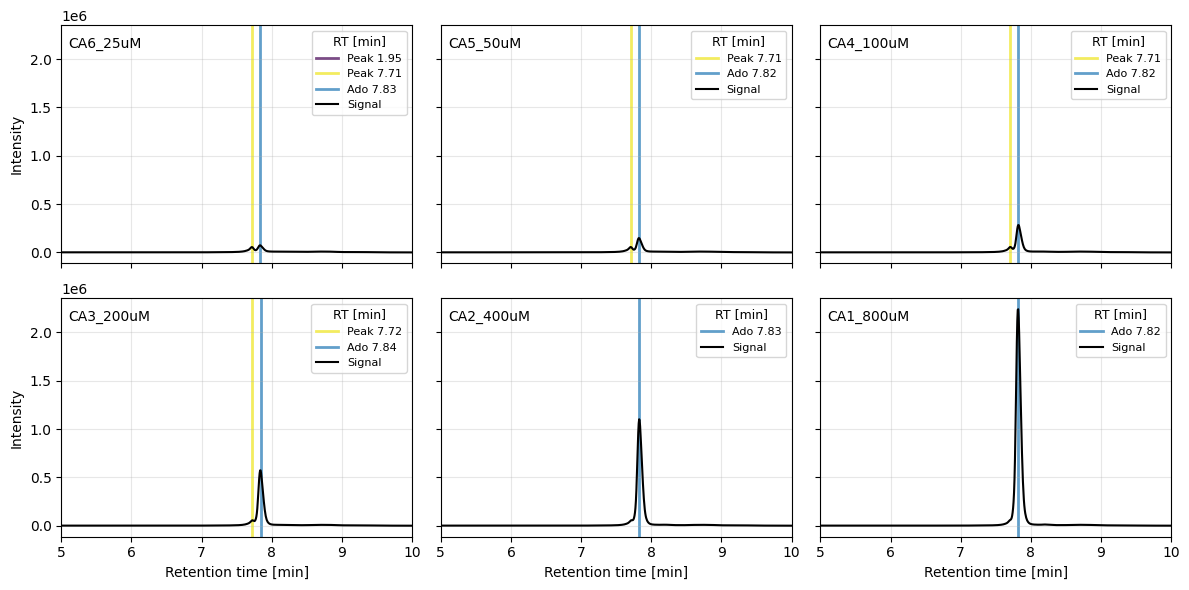

✅ Models have been successfully fitted.


                                         Model Overview                                         
┏━━━━━━━━━━━━┳━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Model Name ┃ AIC ┃ R squared ┃ RMSD          ┃ Equation ┃ Relative Parameter Standard Errors ┃
┡━━━━━━━━━━━━╇━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ linear     │ 198 │ 1.0       │ 12256879.6317 │ Ado * a  │ a: 0.2%,                           │
└────────────┴─────┴───────────┴───────────────┴──────────┴────────────────────────────────────┘

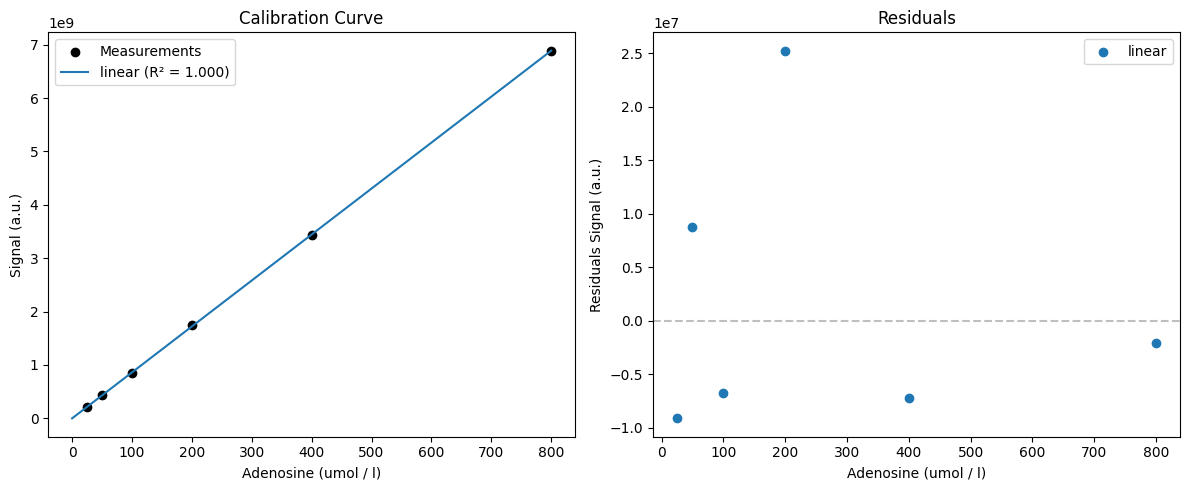

In [2]:
from chromatopy import ChromAnalyzer

# define directory with calibration data
dir_SIH = "data/calibration/adenosine/allotrope"

# read calibration data
analyzer_product = ChromAnalyzer.read_asm(
    path=dir_SIH, ph=7.4, temperature=37, mode="calibration"
)


# define S-adenosyl-L-homocysteine (SAH)
Ado = analyzer_product.define_molecule(
    id="Ado",
    pubchem_cid="60961",
    retention_time=7.8,
    retention_tolerance=0.05,
)

# visualize calibration data
analyzer_product.visualize(n_cols=3, figsize=(12, 6), rt_min=5, rt_max=10)

# fit SAH peaks to linear model
analyzer_product.add_standard(
    molecule=Ado,
    visualize=True,
)

# save SAH molecule for re-use as json file
Ado.save_json("data/calibration/Adenosine.json")


## Process reaction data

Processing of reaction data is similar to the processing of calibration data. The only difference is that the `mode` parameter is set to `timecourse`. Now the previously defined `Molecule` objects for `SAH` and `Ado` are added to the `ChromAnalyzer` object.

__Adding Molecules__  
After loading the `Molecule` objects from the json files, the retention time and retention tolerance can be adjusted, if necessary. 

Instead of defining the `Molecule` objects again, the `Molecule` is added via the `add_molecule` method. This method allows to set the initial concentration of the molecule and the respective unit.

__Defining the Protein__  
Similar to the `Molecule` objects, the `Protein` object is defined using the `define_protein` method.

__Converting to EnzymeML__  
The `to_enzymeml` function converts the `ChromAnalyzer` object to an EnzymeML Document. The method allows to combine the aggregated data of multiple `ChromAnalyzer` objects into a single EnzymeML Document. Thus the `analyzers` parameter is a list of `ChromAnalyzer` objects. Furthermore, the `calculate_concentration` parameter is set to `True` by default, which means that the concentration of the molecules is calculated from the peak area using the calibration curve. The `extrapolate` parameter is set to `False` by default, so concentrations are not extrapolated beyond the calibration range.

Loaded 7 chromatograms.
🎯 Assigned S-Adenosylhomocysteine to 7 peaks
🎯 Assigned Adenosine to 7 peaks


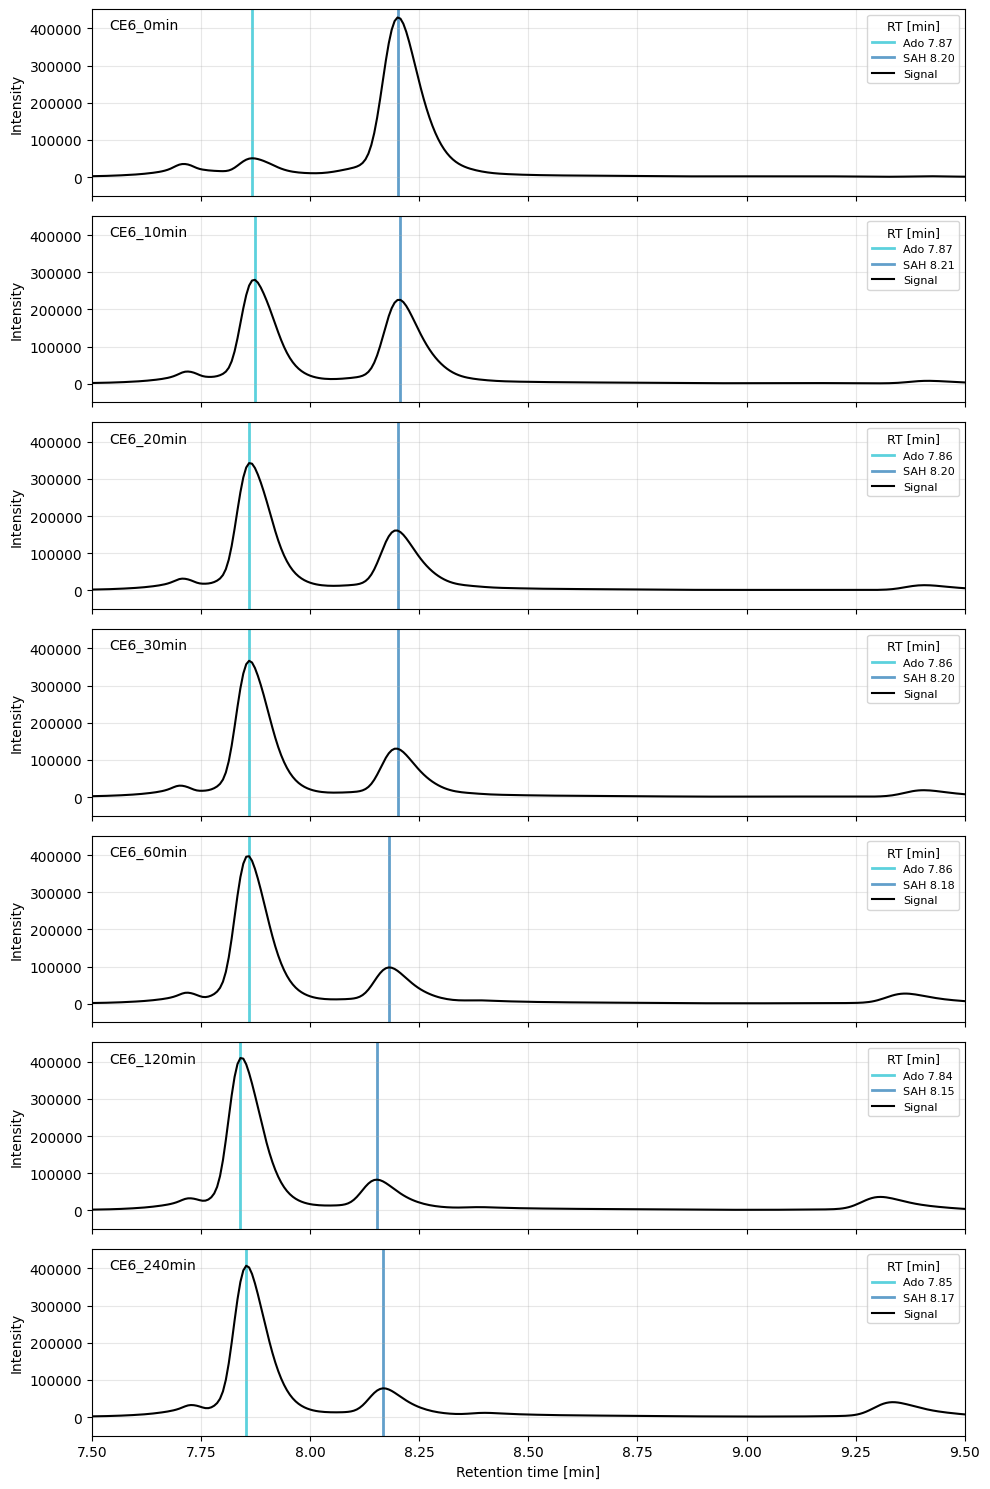

In [3]:
from chromatopy import Molecule, to_enzymeml
from chromatopy.units import uM

# Load SAH molecule from json file
SAH_path = "data/calibration/SAH.json"
SAH = Molecule.read_json(SAH_path)
SAH.retention_time = 8.2
SAH.retention_tolerance = 0.2


# load Ado molecule from json file
Ado_path = "data/calibration/Adenosine.json"
Ado = Molecule.read_json(Ado_path)
Ado.retention_time = 7.84
Ado.retention_tolerance = 0.05

# load reaction data
data_dir = "data/reaction/CE6"
analyzer = ChromAnalyzer.read_asm(
    path=data_dir, ph=7.4, temperature=37, mode="timecourse"
)

# add SAH and Ado molecules to analyzer
analyzer.add_molecule(SAH, init_conc=225, conc_unit=uM)
analyzer.add_molecule(Ado, init_conc=0, conc_unit=uM)

# define enzyme
analyzer.define_protein(
    id="Q80SW1",
    name="SAH Hydrolase",
    init_conc=0.05,
    conc_unit=uM,
)

# visualize chromatogram
analyzer.visualize(
    n_cols=1,
    rt_min=7.5,
    rt_max=9.5,
    figsize=(10, 15),
    assigned_only=True,
)

# export data as EnzymeML Document
enzyme_ml = to_enzymeml(
    analyzers=[analyzer],
    document_name="SAH Hydrolysis assay",
    calculate_concentration=True,
    extrapolate=False,
)

# save EnzymeML Document to file
with open("data/reaction/CE6.json", "w") as f:
    f.write(enzyme_ml.model_dump_json(indent=4))

As a result, the EnzymeML Document contains the aggregated concentration data of the peaks of interest:

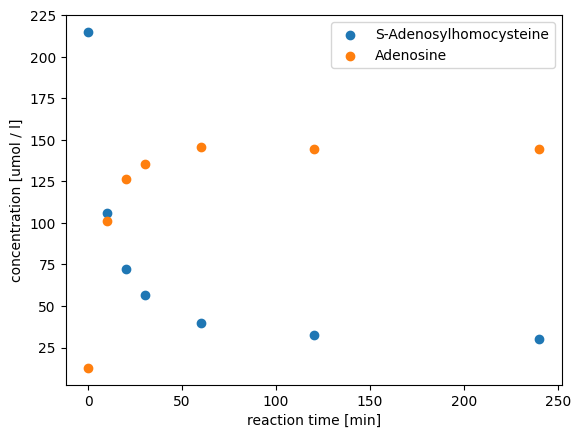

In [4]:
from chromatopy.tools.utility import visualize_enzymeml


visualize_enzymeml(enzyme_ml)